In [18]:
y_train1 = train_70['price_value'].values
y_train1

array([ 19500., 164900.,  26900., ...,  15500.,   6490.,  11300.])

In [19]:
y_train_log1 = np.log(y_train1 - 10)
y_train_log1

np.exp(y_train_log1)  + 10

array([ 19500., 164900.,  26900., ...,  15500.,   6490.,  11300.])

In [255]:
def add_mpvp_min_max(mpvp_col, total):
    dictm = total[['new_cat_price_value', 'price_value_min', 'price_value_max']].drop_duplicates().to_dict()
    def get_from_dict(dictm, col, perc_val):
        index = [i for i, v in dictm.get('new_cat_price_value').items() if v == perc_val][0]
        return dictm.get(col).get(index)

    total[mpvp_col + '_' + 'price_value_min'] = total.apply(lambda row: get_from_dict(dictm, 'price_value_min', row['mpvp1_']), axis=1)
    total[mpvp_col + '_' + 'price_value_max'] = total.apply(lambda row: get_from_dict(dictm, 'price_value_max', row['mpvp1_']), axis=1)

def train_and_submit(train_70, train_30, test, feats, global_min, 
                     model, params, shift = 0, digitize=None, 
                     file_sufix= '', opis='', subfolder='', 
                     learning_curve = False, add_model_column_min = -1, total = None,  
                     save_min=7000, kaggle_min=-1):
    import pandas as pd
    import numpy as np
    from datetime import datetime
    from sklearn.metrics import r2_score, mean_absolute_error
    from scikitplot.estimators import plot_learning_curve

    train_70[feats]
    train_30[feats]
    test[['car_id', *feats]]

    
    time_model_start = datetime.now().strftime("%H:%M:%S")
    
#     shift = 0 #10
    
    X_train = train_70[ feats ].values
    y_train = train_70['price_value'].values
    y_train_log = np.log(y_train) - shift

    if params is not None: 
        model = model(**params)
    model.fit(X_train, y_train_log)

    ## check 
    y_train_pred_log = model.predict(train_30[ feats ].values)
    y_train_pred = np.exp(y_train_pred_log + shift) 
    if digitize is not None: y_train_pred = digitalize_prediction(y_train_pred, train_30, digitize)
    else: y_train_pred[ y_train_pred < global_min] = global_min

    mae = mean_absolute_error(train_30['price_value'].values, y_train_pred)
    r2 = r2_score(train_30['price_value'].values, y_train_pred)
    print(f'mea: {mae}')
    print(f'r2: {r2}')

    ## add_model_column
    model_cl = 'model_' + type(model).__name__ + "_{:.5f}_".format(mae).replace('.', '_') + file_sufix
    if mae <= add_model_column_min and total is not None: 
        X_total = total[feats].values
        y_pred_log = model.predict(X_total)
        y_pred = np.exp(y_pred_log + shift)
        if digitize is not None: y_pred = digitalize_prediction(y_pred, total, digitize)
        else: y_pred[ y_pred < global_min] = global_min
        total[model_cl] = y_pred

    learning_curve_plot = None
    if learning_curve: 
        print("Learning curve for: " + type(model).__name__)
        learning_curve_plot = plot_learning_curve(model, X_train, y_train, cv=3, random_state=0, shuffle=True)

    time_model_end = datetime.now().strftime("%H:%M:%S")

    try:
        if mae <= save_min:
            save_model(file_sufix, subfolder, test, feats, global_min, 
                       model, shift, digitize, mae, r2,
                       details = {"mean_absolute_error" : mae, "r2_score" : r2, 
                                  "vars": ("'"+ "', '".join(list(feats))+"'"), 
                                  "best_params" : params,
                                  "model_start" : time_model_start, "model_end" : time_model_end, 
                                  "opis" : opis}, 
                       learning_curve_plot = learning_curve_plot if learning_curve else None, hist_plt=None,
                       kaggle=(mae < kaggle_min))
    except: 
        print('Error on save!')
        
    return mae, r2, model, model_cl, learning_curve_plot

def digitalize_prediction(y_pred, train_all, digitize):
    import pandas as pd

    result = pd.DataFrame(pd.np.column_stack([train_all[[digitize + '_' + 'price_value_min', digitize + '_' + 'price_value_max']], y_pred]))
    result = result.rename(columns={0: "price_value_min", 1: "price_value_max", 2: "__model__"})         

    result.loc[result['__model__'] < result['price_value_min'], '__model__'] = result.loc[result['__model__'] < result['price_value_min'], 'price_value_min']
    result.loc[result['__model__'] > result['price_value_max'], '__model__'] = result.loc[result['__model__'] > result['price_value_max'], 'price_value_max']
    
    return result['__model__'].values


def save_model(file_sufix, subfolder, test, feats, global_min, model, shift = 0, digitize=False, mae=0.0, r2=0.0,
               details='', learning_curve_plot=None, hist_plt=None, kaggle=None):
    
    from kaggle.api.kaggle_api_extended import KaggleApi
    
    import json
    import pandas as pd
    import numpy as np

    test['car_id']
    
    ## predict test
    X_test = test[feats].values
    y_pred_log = model.predict(X_test)
    y_pred = np.exp(y_pred_log + shift)
    if digitize is not None: y_pred = digitalize_prediction(y_pred, test, digitize)
    else: y_pred[ y_pred < global_min] = global_min
    test['price_value'] = y_pred
    
    file_name = 'output_model/' + subfolder + '/' \
        + ('' if mae==0.0 else "mae_{:.5f}_".format(mae).replace('.', '_')) \
        + ('' if r2==0.0 else "r2_{:.5f}_".format(r2).replace('.', '_')) \
        + type(model).__name__ + '_' \
        + file_sufix + '.csv'
        
    test[['car_id','price_value']].to_csv(file_name, index=False)

    message = json.dumps(details, ensure_ascii=False, indent=4)
    with open(file_name.replace('.csv','.txt'), 'w') as outfile: 
        outfile.write(message)
    
    if learning_curve_plot is not None:
        learning_curve_plot.get_figure().savefig(file_name.replace('.csv','_lc.png'), bbox_inches='tight')

    if hist_plt is not None:
        hist_plt.savefig(file_name.replace('.csv','_hist.png'), bbox_inches='tight')

    if kaggle and details is not None:
        try:
            kaggle_api = KaggleApi()
            kaggle_api.authenticate()

            print(message)
            kaggle_api.competition_submit(file_name.replace('~/pml7/konkurs/', ''), message, 'dw-car-price-prediction')
            leaderboard = kaggle_api.competition_view_leaderboard('dw-car-price-prediction')
            print(pd.DataFrame(leaderboard['submissions'])[['teamName', 'submissionDate', 'score']].head())
        except: print('Kaggle API fail')


In [74]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_cat(df, var):
    plt.figure(figsize=(20,8))

    plt.subplot(1,2,1)
    plt.title('Histogram')
    sns.countplot(df[var], palette=("cubehelix"))

    plt.subplot(1,2,2)
    plt.title(var + ' vs Price')
    sns.boxplot(x=df[var], y=df['price_value_log'], palette=("cubehelix"))

    plt.show()

def print_plots_by_type(total, type = [np.object, bool], min_c = 9.0, max_c = 100., max_values=30): 
    index = 0
    for cl in total.columns[2:]:
        index += 1
        if total[cl].dtype in type:
            rows = len(total.index)
            nas = rows - total[cl].isna().sum()
            nas_perc = nas/rows*100
            values = len(total[cl].value_counts())
            print(str(index) + ': ' + cl + " [{:.2f}%=".format(nas_perc) + str(nas) + '/' + str(rows) + ' #' + str(values) + ']: ')
            if max_c >= nas_perc >= min_c: 
                if 1 < values < max_values:
                    print(total[cl].value_counts())
                    plot_cat(total, cl)
                    plt.clf()
                    plt.cla()
                    plt.close()

In [3]:
from mozo import compare_and_combine_2, Diff, merge_with_features, num_to_range_categories
import pandas as pd
import numpy as np
np.random.seed(0)

import xgboost as xgb

from scipy import stats
import math 
import datetime 

from sklearn.metrics import r2_score, mean_absolute_error


In [ ]:
def replace_feature(current_vars, old, new):
    current_vars = np.array(current_vars)
    current_vars = list(current_vars)
    current_vars.remove(old)
    current_vars.append(new)
    return np.sort(current_vars)

# replace_feature(['a', 'b', 'c'], 'b', 'e')

import random

def mutate_rand_feature(current_vars, all_vars, added_so_far, removed_so_far):
    
    def diff(a, b):
        return np.concatenate([np.setdiff1d(a,b), np.setdiff1d(b,a)])
    
#     vars_to_draw_from = diff(current_vars, all_vars)
    vars_to_draw_from = [x for x in all_vars if x not in current_vars]
#     vars_to_draw_from = diff(vars_to_draw_from, added_so_far)
    vars_to_draw_from = [x for x in vars_to_draw_from if x not in added_so_far]
#     vars_to_draw_from = diff(vars_to_draw_from, removed_so_far)
    vars_to_draw_from = [x for x in vars_to_draw_from if x not in removed_so_far]
    
    last_trial = False
    if len(vars_to_draw_from) == 1: last_trial = True

    print(vars_to_draw_from)
    added = np.random.choice(vars_to_draw_from, 1)[0]
    removed = np.random.choice(np.setdiff1d(current_vars, added), 1)[0]
    print(removed)
    print(added)
    current_vars = replace_feature(current_vars, removed, added)
    print(current_vars)
    
    return current_vars, added, np.append(added_so_far, added), removed, np.append(removed_so_far, removed), last_trial

# added_so_far = []
# removed_so_far = []
# current_vars = ['a', 'b', 'c', 'd', 'e']
# all_vars = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i']
# mutate_rand_feature(current_vars, all_vars, added_so_far, removed_so_far)

In [4]:
total = pd.read_csv('~/pml7/konkurs/output/newest_total_20201031_15_28.h5.csv')
total.info(verbose=True)

/home/conda/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (3,86,161) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160616 entries, 0 to 160615
Data columns (total 216 columns):
 #   Column                                              Dtype  
---  ------                                              -----  
 0   breadcrumb                                          object 
 1   created_at                                          object 
 2   price_currency                                      object 
 3   price_details                                       object 
 4   price_value                                         float64
 5   seller_address                                      object 
 6   seller_name                                         object 
 7   seller_type                                         object 
 8   feature_czujniki_parkowania_przednie                bool   
 9   feature_poduszka_powietrzna_chroniąca_kolana        bool   
 10  feature_kurtyny_powietrzne                          bool   
 11  feature_klimatyzacja_dwustrefowa      

3: price_value [66.30%=106494/160616 #7821]: 
94: created_at_unix [100.00%=160616/160616 #11960]: 
95: created_at_unix_na_mean [100.00%=160616/160616 #11960]: 
96: pln_to_eur [100.00%=160616/160616 #11]: 
4.1943    123936
4.2207     30795
4.1878      5456
4.1737       202
4.1585       198
4.1836        16
4.1688         5
4.1729         4
4.1767         2
4.1714         1
4.1504         1
Name: pln_to_eur, dtype: int64


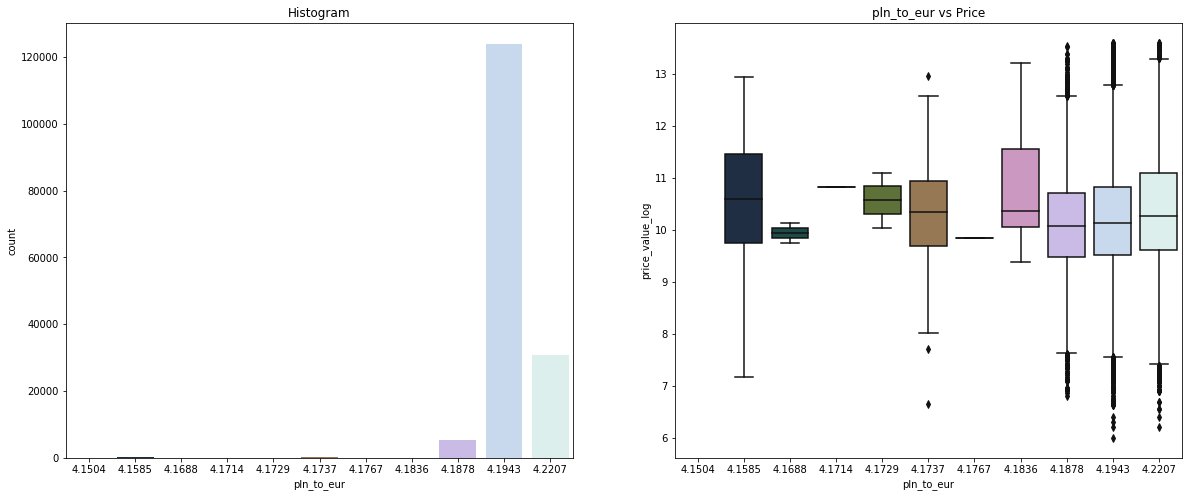

97: price_value_pln [66.30%=106494/160616 #7968]: 
98: price_value_pln_log_transl [66.30%=106494/160616 #7968]: 
99: latitude [100.00%=160616/160616 #12727]: 
100: latitude_na_mean [100.00%=160616/160616 #12727]: 
101: longitude [100.00%=160616/160616 #12658]: 
102: longitude_na_mean [100.00%=160616/160616 #12658]: 
103: param_liczba_miejsc [88.83%=142672/160616 #9]: 
5.0    123298
7.0      8121
4.0      7025
2.0      1711
9.0      1059
6.0       572
8.0       504
3.0       378
1.0         4
Name: param_liczba_miejsc, dtype: int64


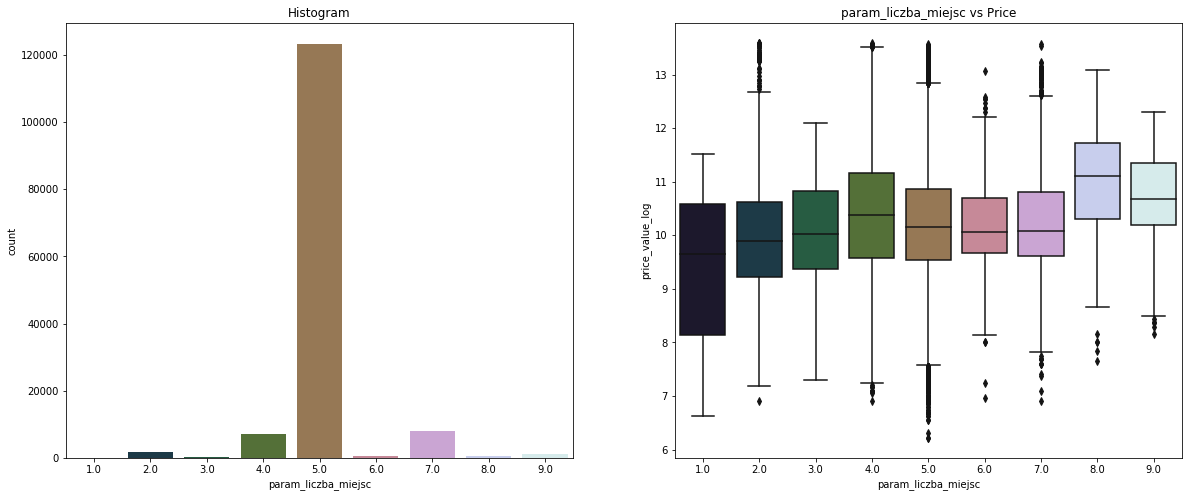

107: param_liczba_drzwi [100.00%=160616/160616 #10]: 
 5.0    107802
 4.0     22907
-1.0     14811
 3.0     11029
 2.0      3887
 6.0       147
 7.0        18
 8.0         6
 1.0         5
 9.0         4
Name: param_liczba_drzwi, dtype: int64


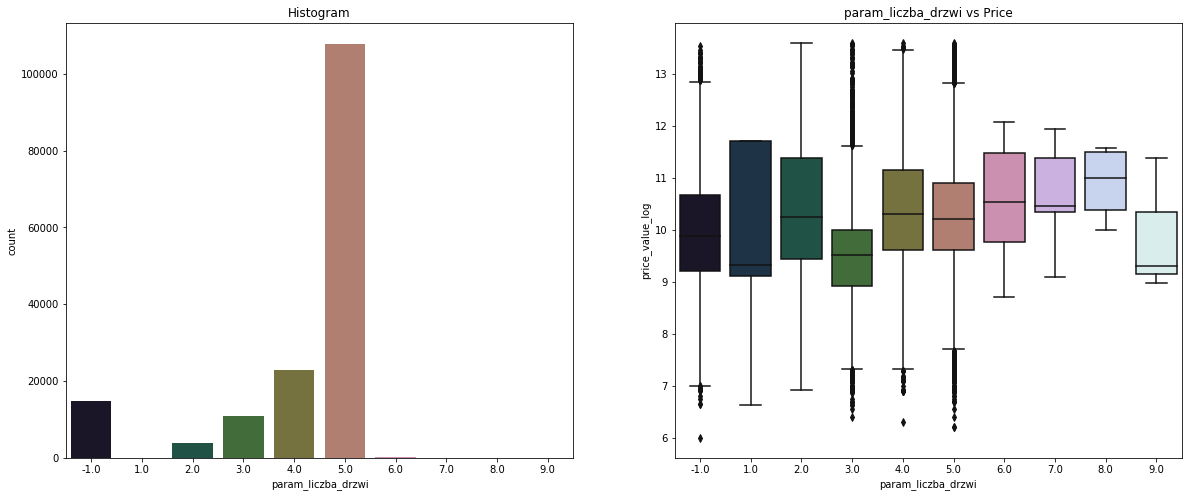

133: param_pierwsza_rejestracja_date [36.28%=58276/160616 #7126]: 
134: price_value_log [66.30%=106494/160616 #7821]: 
159: new_cat_seller_address [100.00%=160616/160616 #83]: 
 0.000100    132698
 0.006195       994
 0.001377       884
 0.004923       790
 0.004743       761
              ...  
 0.001091       175
 0.001047       168
 0.001022       164
 0.001003       161
-1.000000       161
Name: new_cat_seller_address, Length: 83, dtype: int64


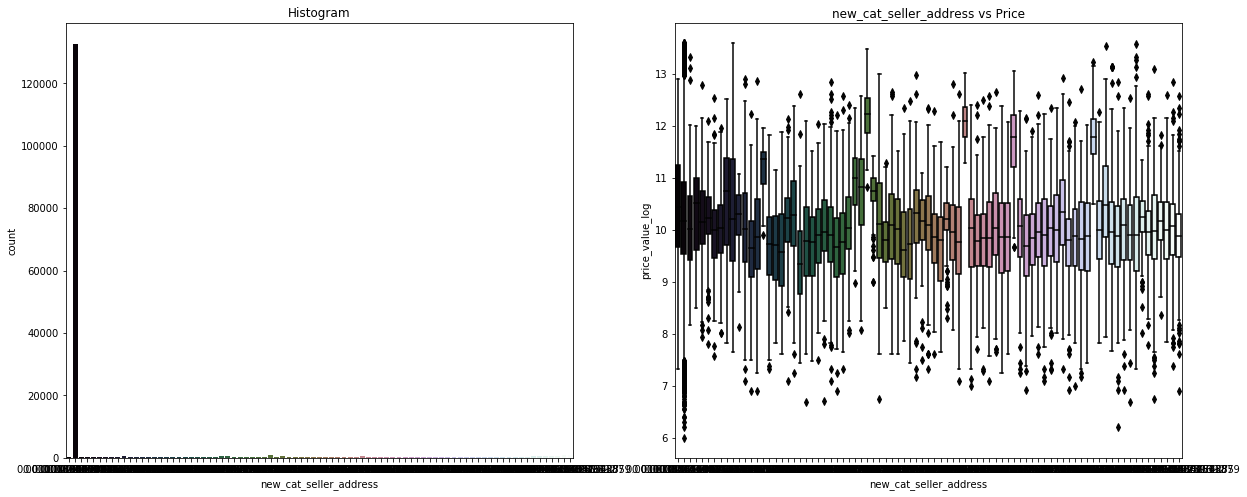

161: model_8790 [100.00%=160616/160616 #156457]: 
187: param_wartość_wykupu_2 [100.00%=160616/160616 #354]: 
-1.00        160209
 1.00            15
 1000.00          6
 30000.00         3
 20000.00         3
              ...  
 33000.00         1
 74639.91         1
 29755.00         1
 794.68           1
 1268.00          1
Name: param_wartość_wykupu_2, Length: 354, dtype: int64


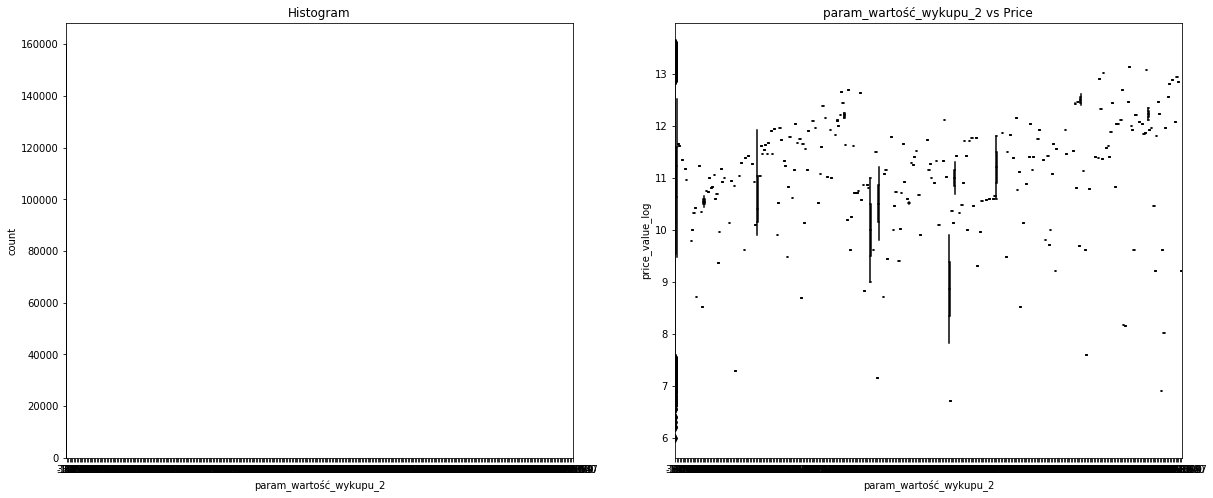

188: param_liczba_pozostałych_rat_2 [100.00%=160616/160616 #70]: 
-1.0     160174
 36.0        81
 48.0        30
 60.0        24
 47.0        21
          ...  
 13.0         1
 7.0          1
 2.0          1
 84.0         1
 56.0         1
Name: param_liczba_pozostałych_rat_2, Length: 70, dtype: int64


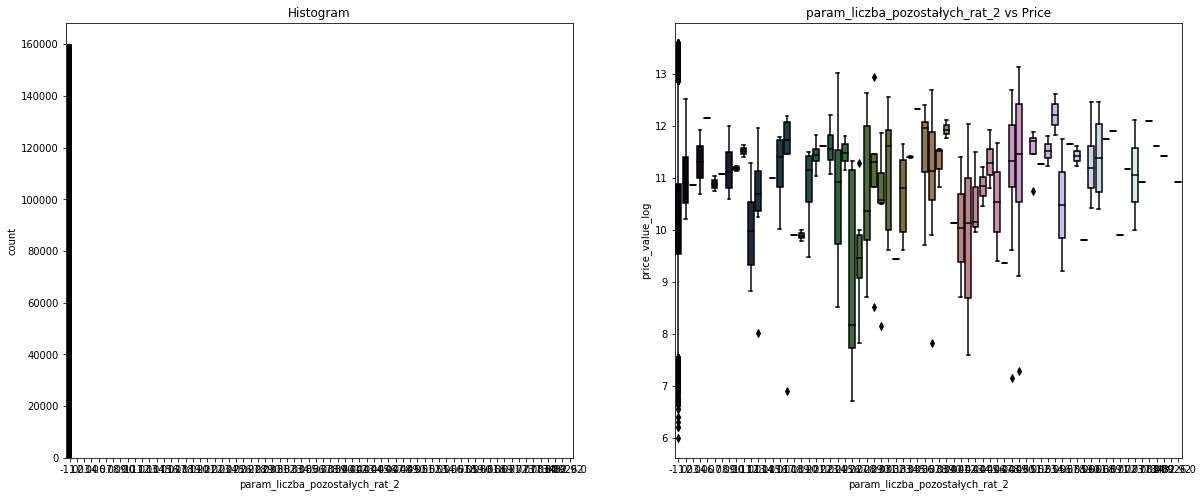

189: param_opłata_początkowa_2 [100.00%=160616/160616 #259]: 
-1.0         160204
 1.0             31
 15000.0         13
 20000.0         12
 5000.0           8
              ...  
 47500.0          1
 20325.0          1
 14199.0          1
 2500.0           1
 111000.0         1
Name: param_opłata_początkowa_2, Length: 259, dtype: int64


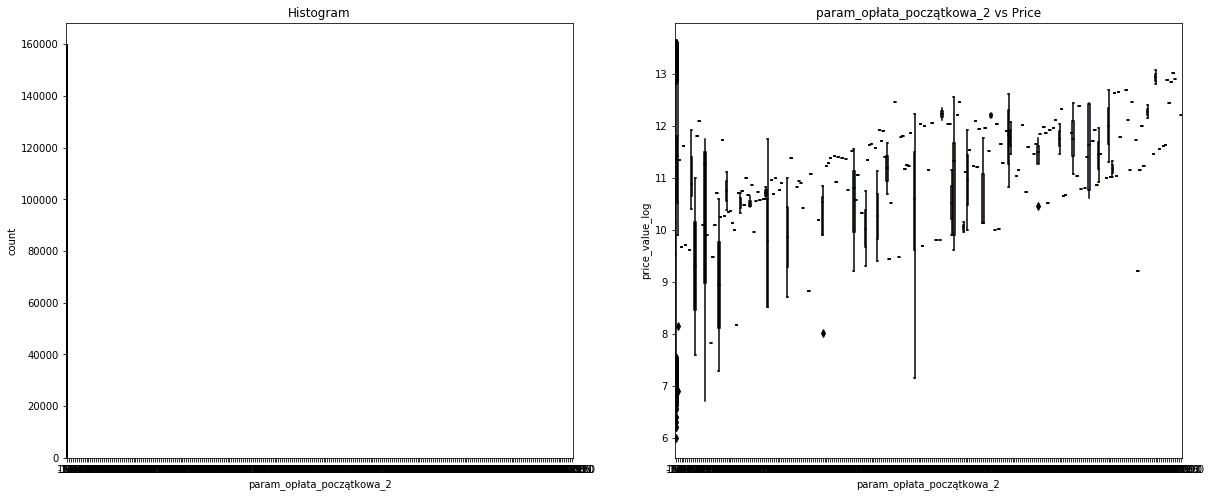

191: param_miesięczna_rata_2 [100.00%=160616/160616 #534]: 
-1.00       159889
 400.00         28
 600.00         21
 500.00         15
 700.00         13
             ...  
 2780.09         1
 168.00          1
 4162.80         1
 991.00          1
 2514.00         1
Name: param_miesięczna_rata_2, Length: 534, dtype: int64


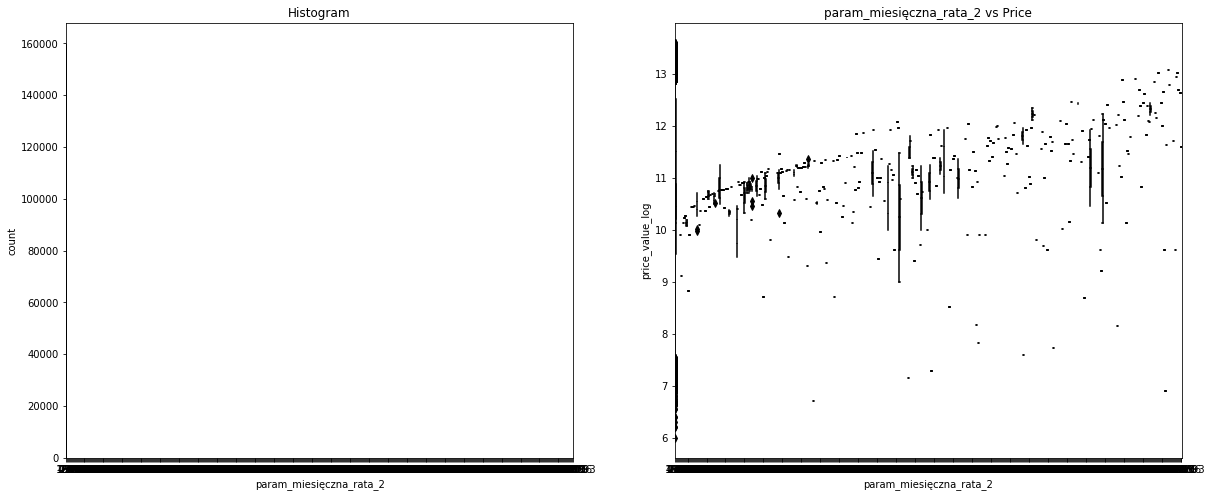

192: param_pierwsza_rejestracja_date_na [100.00%=160616/160616 #7127]: 
193: model_XGBRegressor_5856_36229_ [100.00%=160616/160616 #156820]: 
194: param_liczba_miejsc_2 [100.00%=160616/160616 #10]: 
 5.000000e+00    123298
-1.000000e+11     17944
 7.000000e+00      8121
 4.000000e+00      7025
 2.000000e+00      1711
 9.000000e+00      1059
 6.000000e+00       572
 8.000000e+00       504
 3.000000e+00       378
 1.000000e+00         4
Name: param_liczba_miejsc_2, dtype: int64


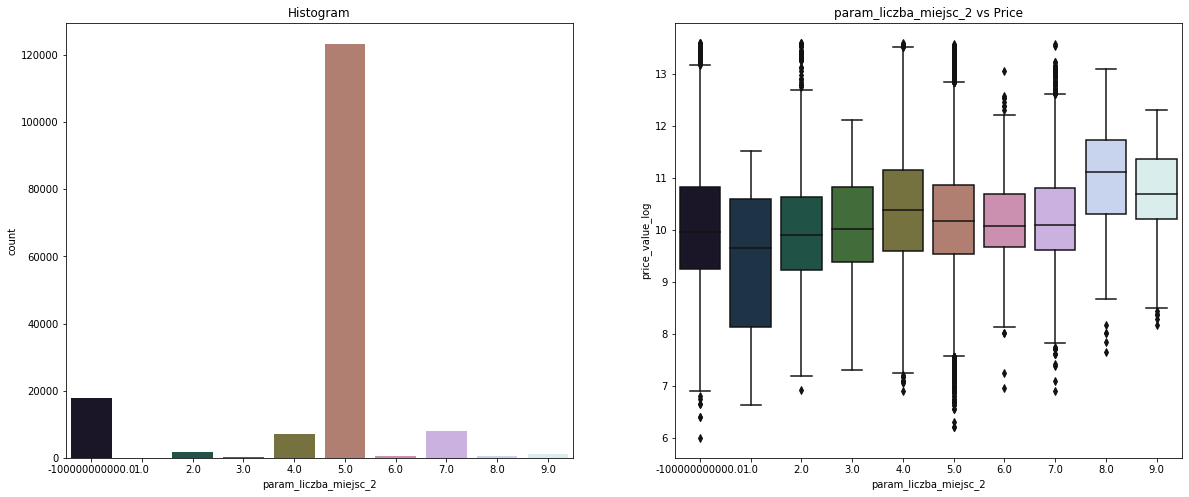

195: model_XGBRegressor_3293_22097_ [100.00%=160616/160616 #156810]: 
196: model_RandomForestRegressor_7089_27166_feats2 [100.00%=160616/160616 #160276]: 
197: model_XGBRegressor_3422_09438_start_vars_train_100 [100.00%=160616/160616 #156420]: 
201: param_moc_norm [91.18%=146446/160616 #602]: 
5.010635    9730
4.941642    9503
4.499810    6630
4.653960    6538
4.700480    6462
            ... 
6.529419       1
6.461468       1
6.156979       1
8.389360       1
3.332205       1
Name: param_moc_norm, Length: 602, dtype: int64


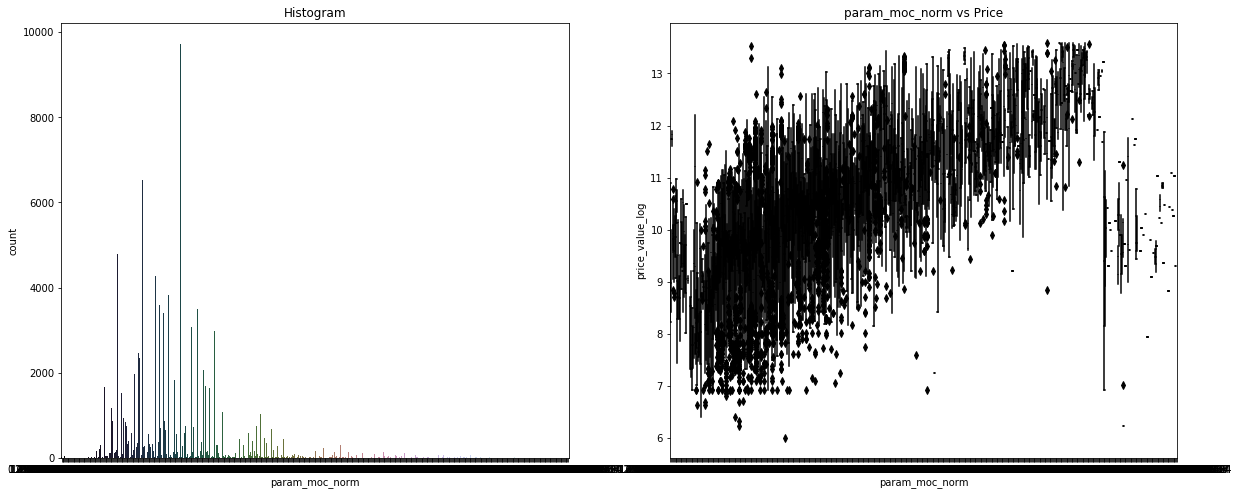

202: param_pojemność_skokowa_norm [95.23%=152962/160616 #1424]: 
203: ogloszenie_rok [100.00%=160616/160616 #3]: 
 2018.0    160452
-1.0          161
 2017.0         3
Name: ogloszenie_rok, dtype: int64


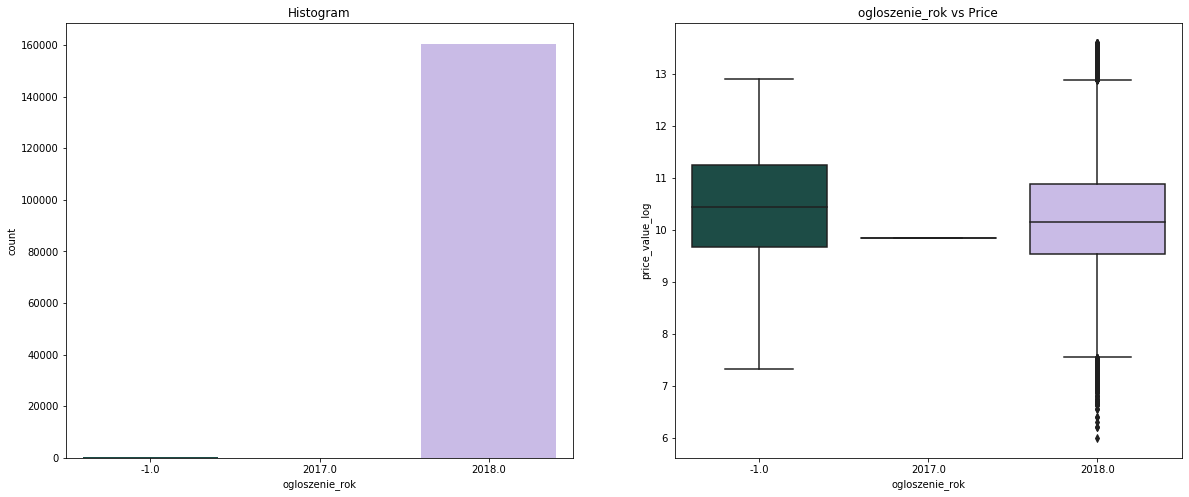

204: ogloszenie_miesiac [100.00%=160616/160616 #5]: 
 3.0     122773
 2.0      37655
-1.0        161
 1.0         24
 12.0         3
Name: ogloszenie_miesiac, dtype: int64


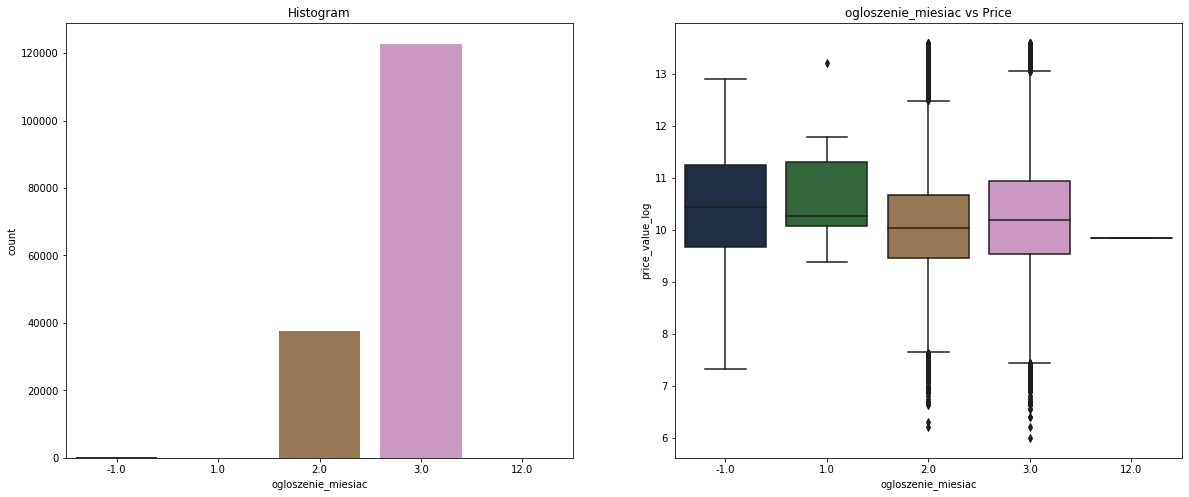

205: ogloszenie_dzien_tyg [100.00%=160616/160616 #8]: 
 0.0    32190
 6.0    27216
 5.0    25216
 4.0    25056
 3.0    19951
 2.0    16375
 1.0    14451
-1.0      161
Name: ogloszenie_dzien_tyg, dtype: int64


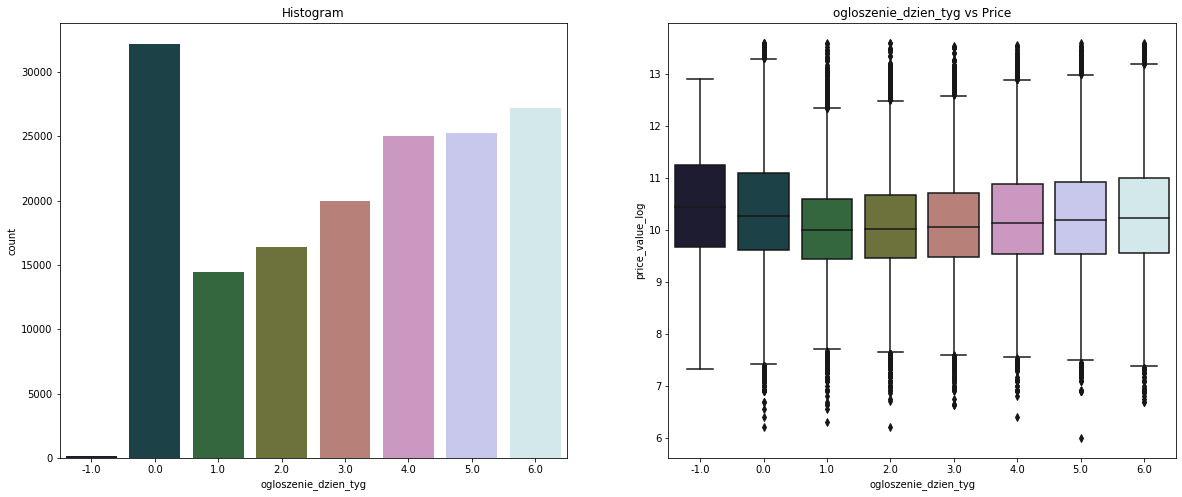

206: ogloszenie_godzina [100.00%=160616/160616 #25]: 
 12.0    12899
 15.0    12498
 16.0    12388
 13.0    12343
 14.0    11950
 11.0    11628
 10.0    11362
 17.0    10795
 9.0      9657
 18.0     9533
 21.0     8321
 20.0     7911
 19.0     7898
 22.0     6831
 8.0      5375
 23.0     3163
 7.0      2421
 0.0      1386
 6.0       903
 1.0       495
 2.0       282
 5.0       165
-1.0       161
 3.0       153
 4.0        98
Name: ogloszenie_godzina, dtype: int64


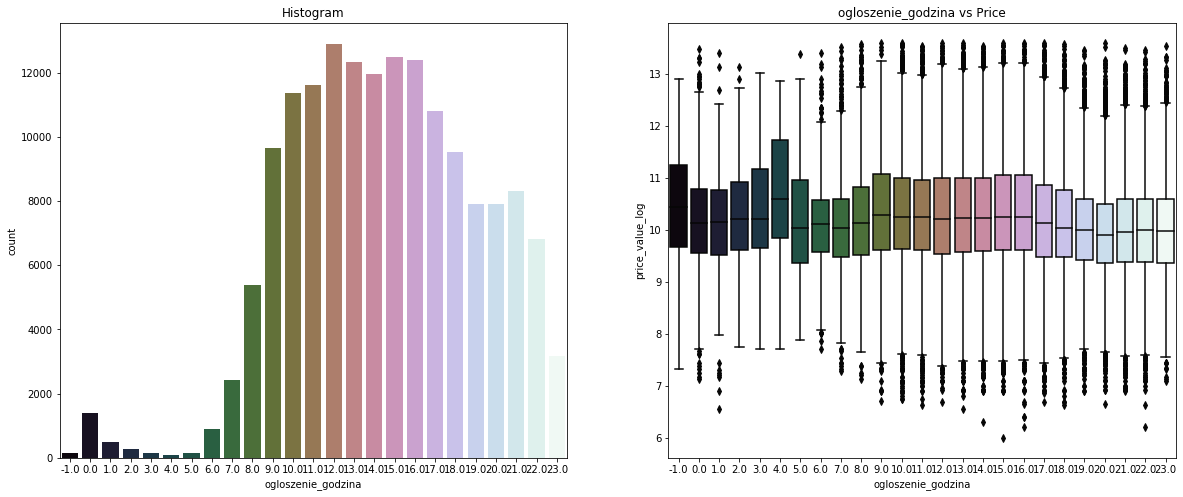

207: ogloszenie_dni_wisi [100.00%=160616/160616 #11960]: 


In [7]:
print_plots_by_type(total, type =[np.number], max_values=1000)

1: price_currency [100.00%=160616/160616 #2]: 
PLN    160288
EUR       328
Name: price_currency, dtype: int64


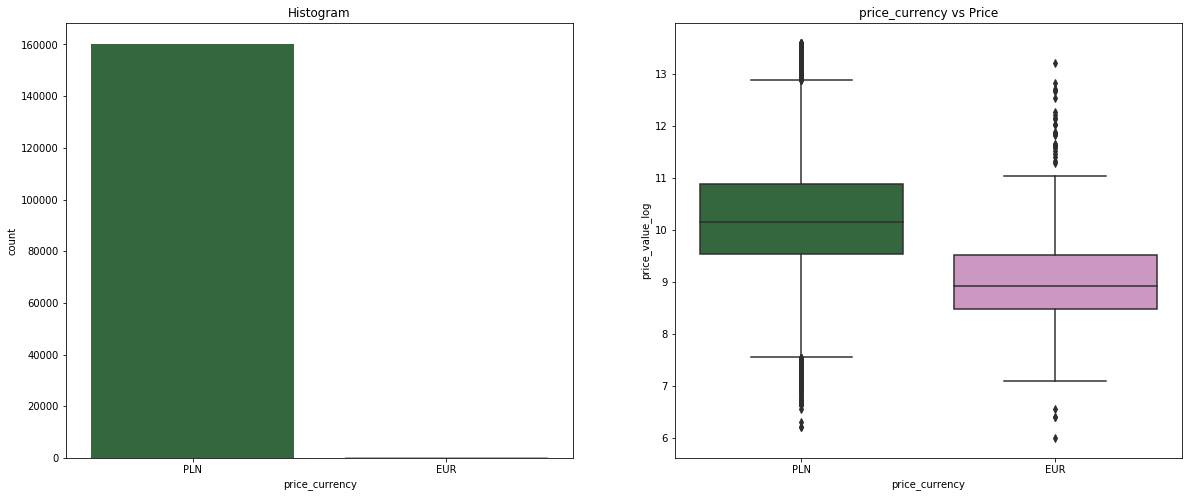

2: price_details [66.30%=106494/160616 #16]: 
Cena Brutto, Do negocjacji                                                    49422
Cena Brutto                                                                   29148
Cena Brutto, Faktura VAT                                                      13781
Cena Brutto, Do negocjacji, Faktura VAT                                        7528
Cena Netto, Faktura VAT                                                        2828
Cena Netto, Do negocjacji, Faktura VAT                                         2277
Cena Netto                                                                      716
Cena Netto, Do negocjacji                                                       685
Brutto                                        , Do negocjacji                    51
Brutto                                                                           27
Brutto                    , Faktura VAT                                          10
Brutto                    , Fa

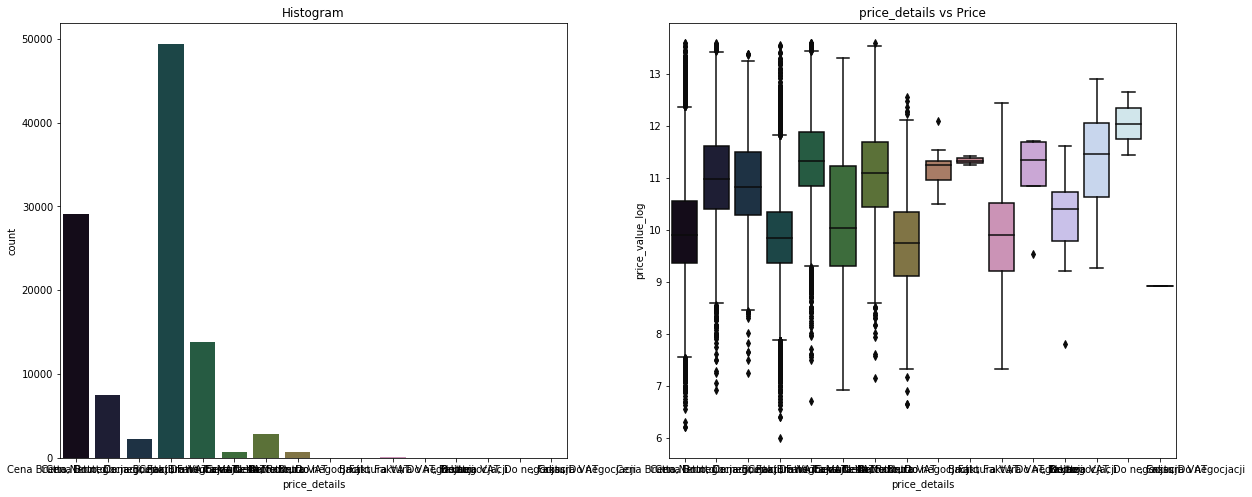

4: seller_address [99.90%=160455/160616 #12808]: 
5: seller_name [60.53%=97228/160616 #7005]: 
6: seller_type [99.90%=160455/160616 #2]: 
Dealer            97228
Osoba prywatna    63227
Name: seller_type, dtype: int64


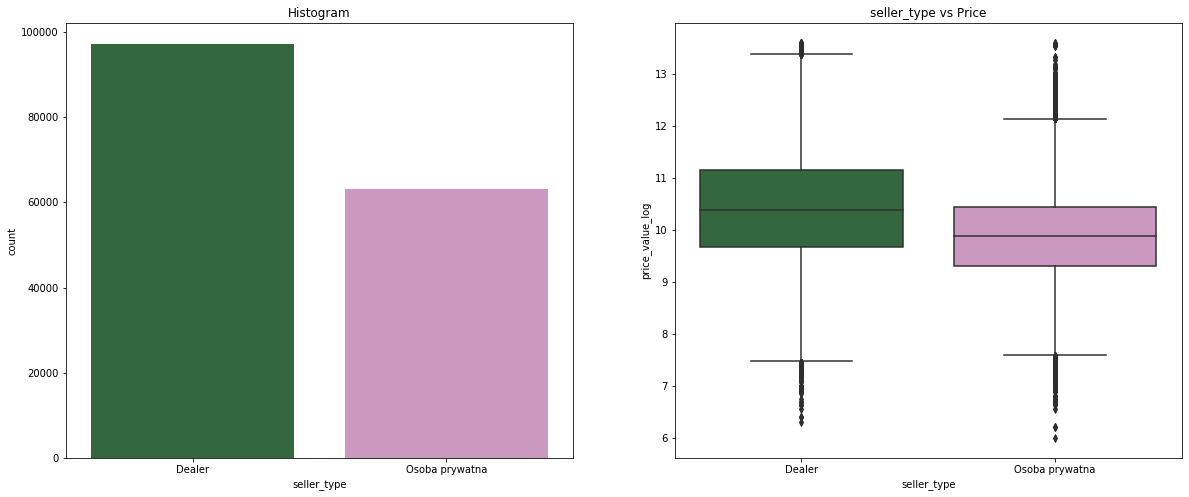

78: param_vin [22.23%=35701/160616 #35257]: 
81: param_kategoria [99.90%=160455/160616 #1]: 
83: param_wartość_wykupu [0.25%=407/160616 #353]: 
85: param_liczba_pozostałych_rat [0.28%=442/160616 #85]: 
86: param_oferta_od [99.90%=160455/160616 #2]: 
Firmy              97223
Osoby prywatnej    63232
Name: param_oferta_od, dtype: int64


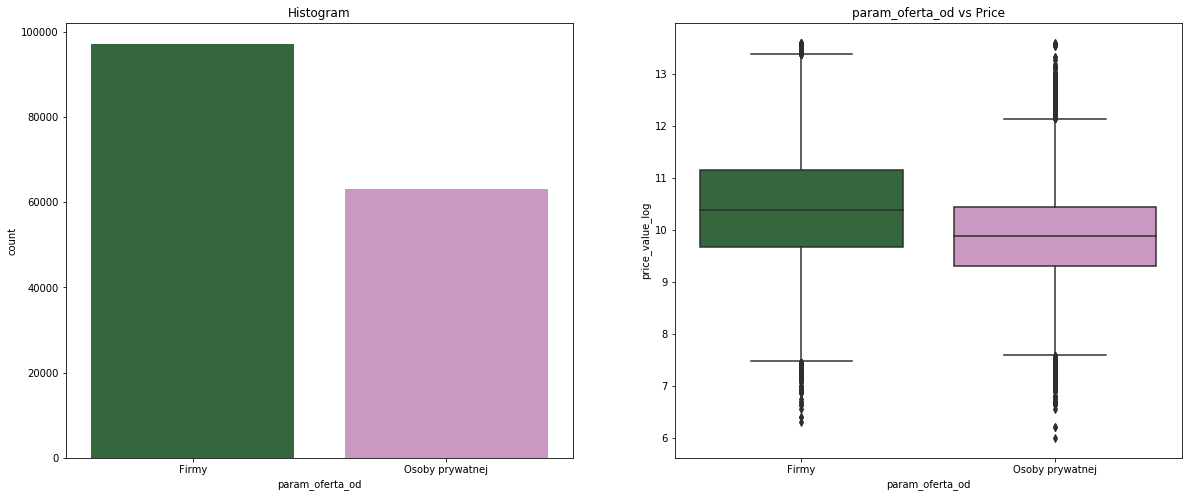

87: param_opłata_początkowa [0.26%=412/160616 #258]: 
91: param_stan [99.90%=160455/160616 #2]: 
Używane    146217
Nowe        14238
Name: param_stan, dtype: int64


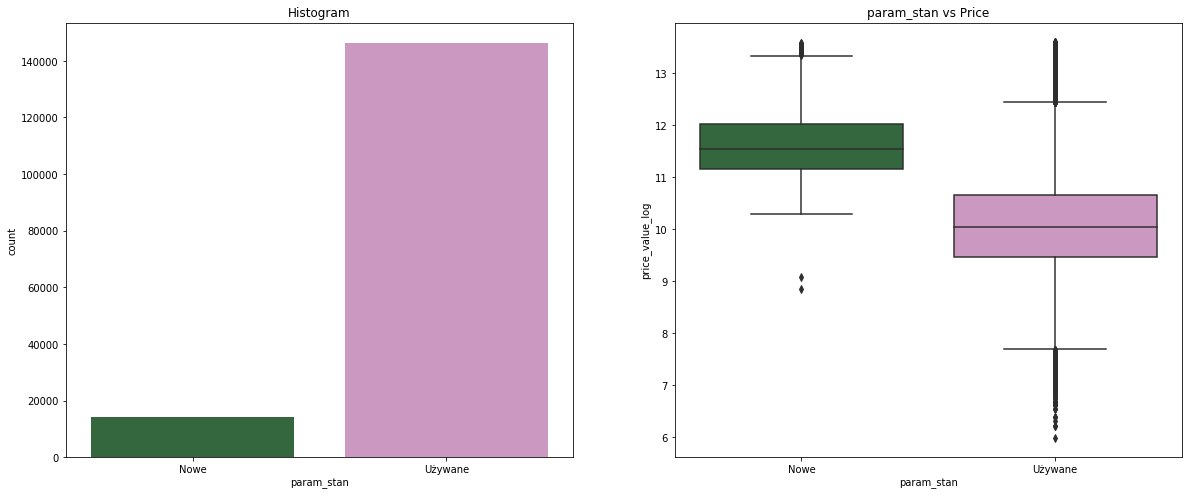

104: param_marka_pojazdu [99.90%=160455/160616 #103]: 
105: param_model_pojazdu [99.90%=160455/160616 #1049]: 
106: param_kod_silnika [10.75%=17265/160616 #237]: 
108: param_pierwsza_rejestracja [36.28%=58276/160616 #8160]: 
109: param_kraj_pochodzenia [68.01%=109232/160616 #35]: 
110: param_skrzynia_biegów [94.56%=151871/160616 #5]: 
Manualna                                 110681
Automatyczna hydrauliczna (klasyczna)     27955
Automatyczna dwusprzęgłowa (DCT, DSG)      9629
Automatyczna bezstopniowa (CVT)            2302
Półautomatyczna (ASG, Tiptronic)           1304
Name: param_skrzynia_biegów, dtype: int64


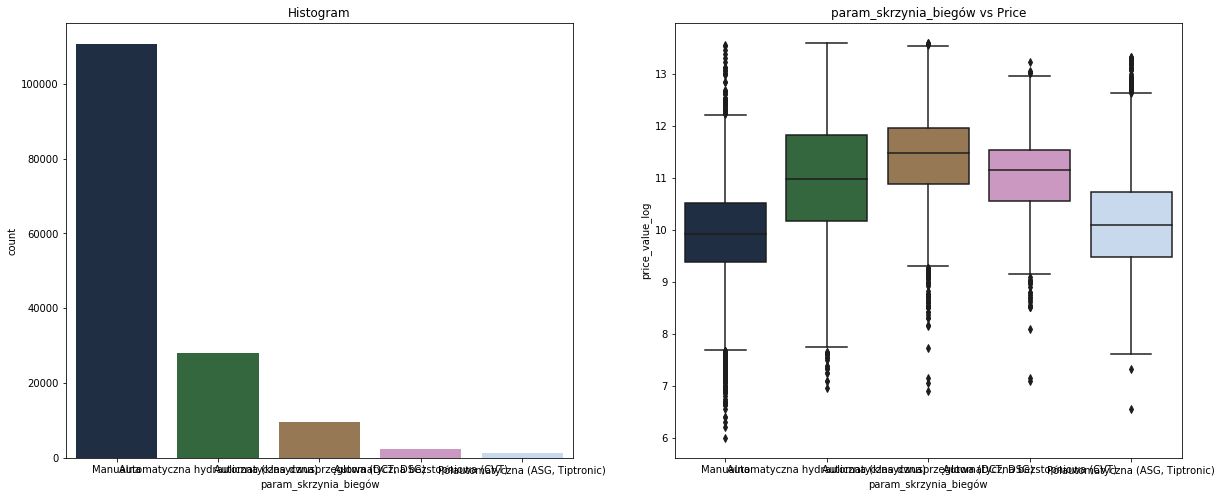

112: param_kolor [99.90%=160455/160616 #14]: 
Czarny        39267
Srebrny       29515
Szary         21927
Biały         17687
Niebieski     17423
Inny kolor    11467
Czerwony       6246
Brązowy        4284
Zielony        3872
Bordowy        2850
Złoty          2448
Beżowy         2113
Fioletowy       736
Żółty           620
Name: param_kolor, dtype: int64


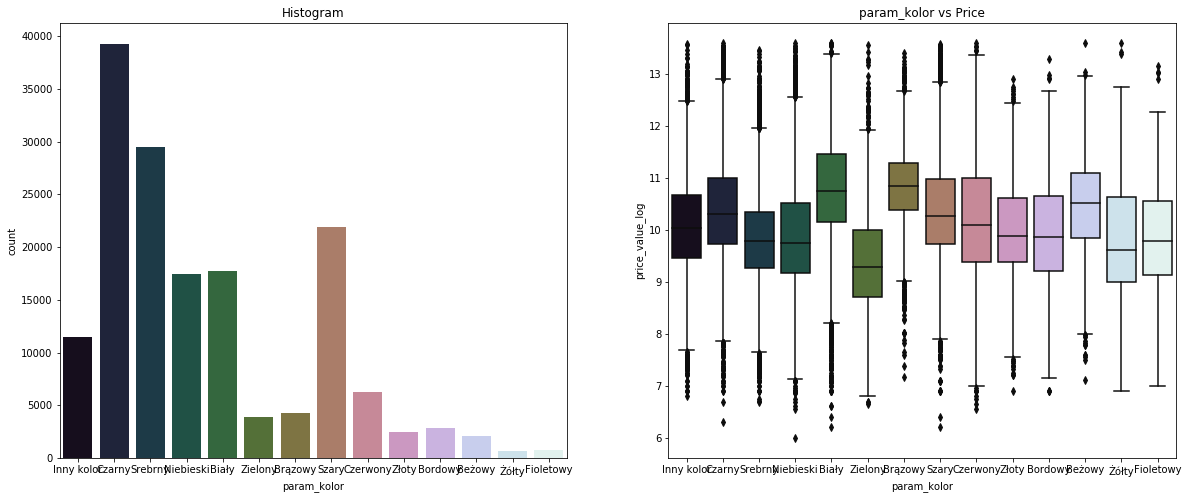

118: param_napęd [84.68%=136003/160616 #5]: 
Na przednie koła                 99630
Na tylne koła                    12967
4x4 (stały)                      10641
4x4 (dołączany automatycznie)    10341
4x4 (dołączany ręcznie)           2424
Name: param_napęd, dtype: int64


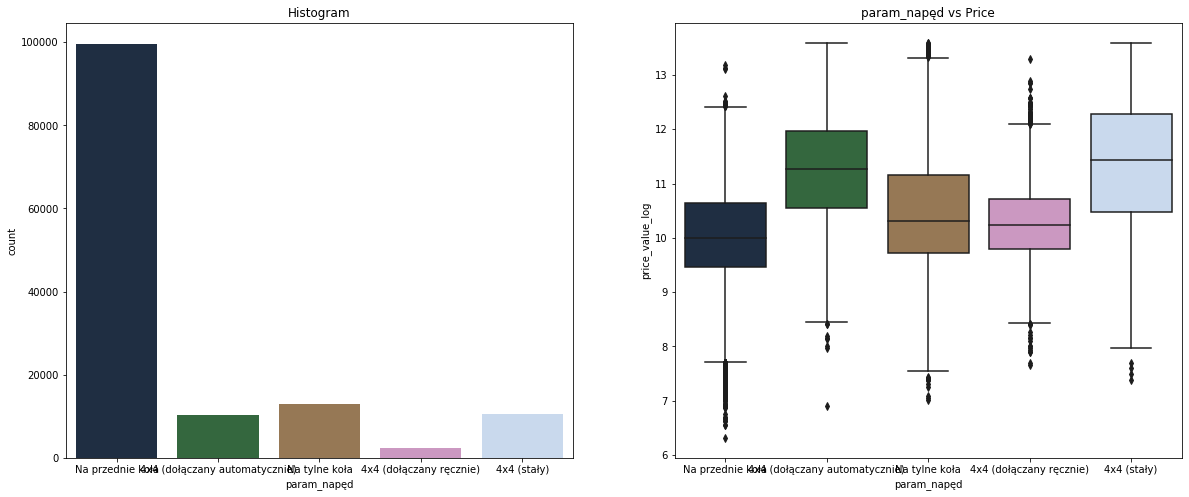

120: param_rodzaj_paliwa [99.90%=160455/160616 #8]: 
Diesel         81448
Benzyna        70631
Benzyna+LPG     7187
Hybryda          960
Elektryczny      125
Benzyna+CNG      102
Wodór              1
Etanol             1
Name: param_rodzaj_paliwa, dtype: int64


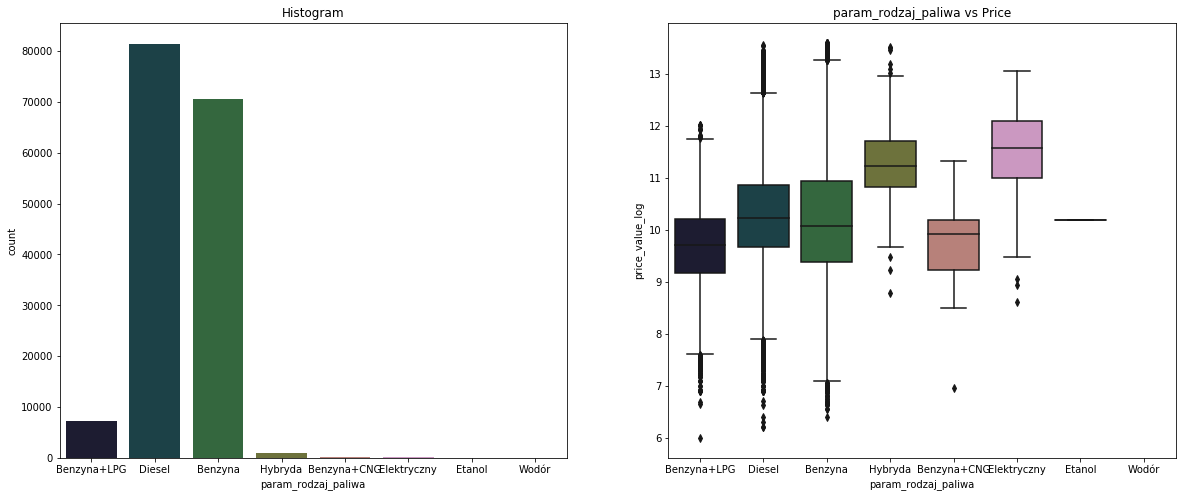

121: param_typ [99.90%=160454/160616 #20]: 
Kombi                   33012
Sedan                   27051
Kompakt                 24864
SUV                     24263
Auta miejskie           20532
Minivan                 19784
Auta małe                5407
Coupe                    4011
Kabriolet                1348
sedan/coupe/cabrio         45
hatchback                  43
sedan/coupe                40
coupe/cabrio               37
minivan/city-car            6
city-car/suv                3
compact/minivan             3
coupe/cabrio/minivan        2
compact/sedan               1
others                      1
not enough details          1
Name: param_typ, dtype: int64


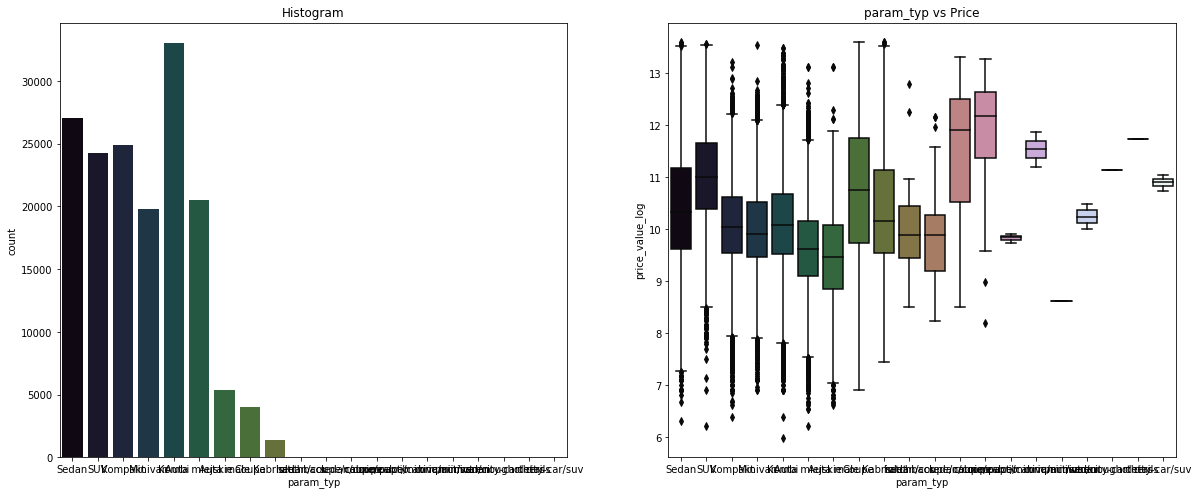

122: param_emisja_co2 [1.94%=3117/160616 #219]: 
130: param_miesięczna_rata [0.45%=727/160616 #533]: 
131: param_wersja [77.49%=124457/160616 #522]: 
160: new_cat_price_value [66.30%=106494/160616 #20]: 
perc_65    5698
perc_40    5665
perc_15    5446
perc_80    5404
perc_50    5370
perc_20    5357
perc_70    5354
perc_90    5340
perc_10    5339
perc_85    5338
perc_95    5328
perc_25    5310
perc_30    5282
perc_05    5280
perc_45    5245
perc_75    5242
perc_60    5217
perc_00    5201
perc_35    5041
perc_55    5037
Name: new_cat_price_value, dtype: int64


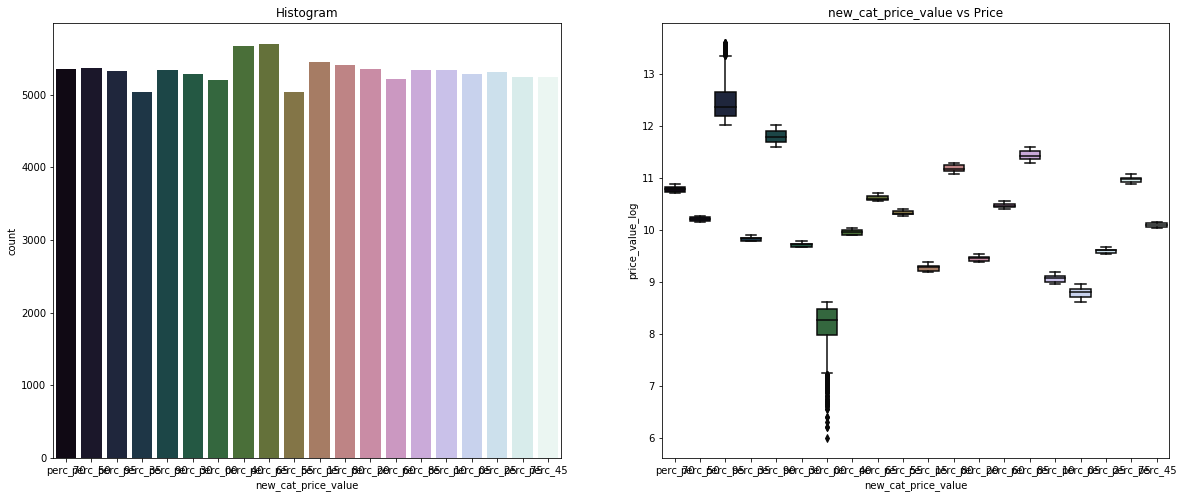

162: param_rodzaj_paliwa_2 [99.90%=160454/160616 #6]: 
Diesel         81448
Benzyna        70632
Benzyna+LPG     7187
Hybryda          960
Elektryczny      125
Benzyna+CNG      102
Name: param_rodzaj_paliwa_2, dtype: int64


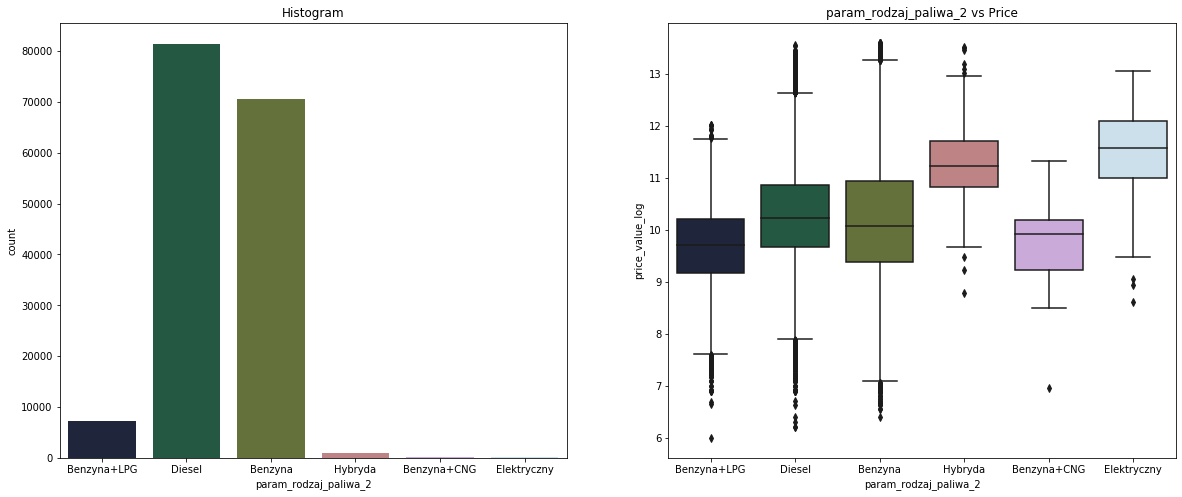

164: param_skrzynia_biegów_2 [94.56%=151871/160616 #5]: 
Manualna                                 110681
Automatyczna hydrauliczna (klasyczna)     27955
Automatyczna dwusprzęgłowa (DCT, DSG)      9629
Automatyczna bezstopniowa (CVT)            2302
Półautomatyczna (ASG, Tiptronic)           1304
Name: param_skrzynia_biegów_2, dtype: int64


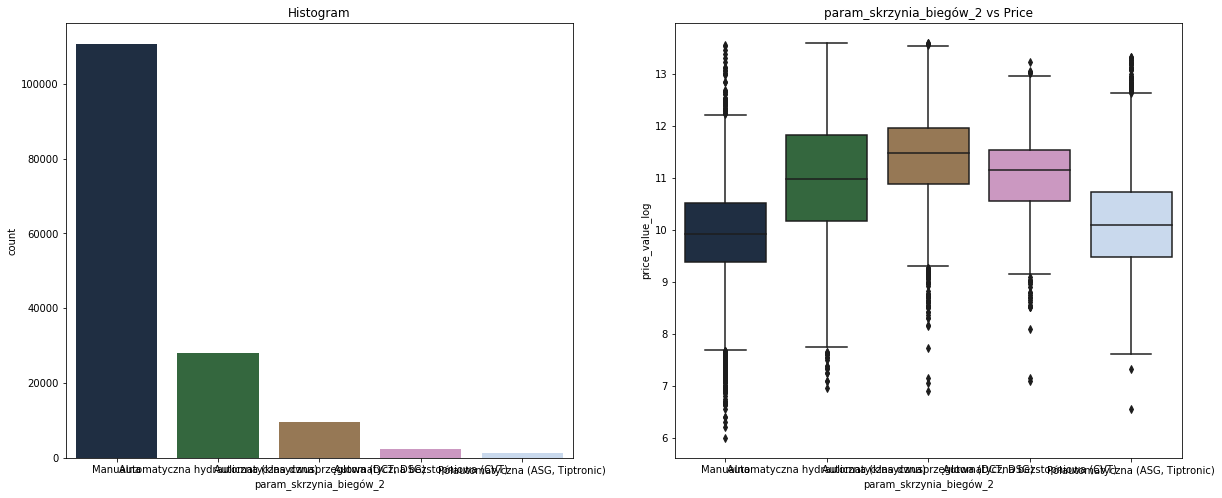

166: param_napęd_2 [84.68%=136003/160616 #5]: 
Na przednie koła                 99630
Na tylne koła                    12967
4x4 (stały)                      10641
4x4 (dołączany automatycznie)    10341
4x4 (dołączany ręcznie)           2424
Name: param_napęd_2, dtype: int64


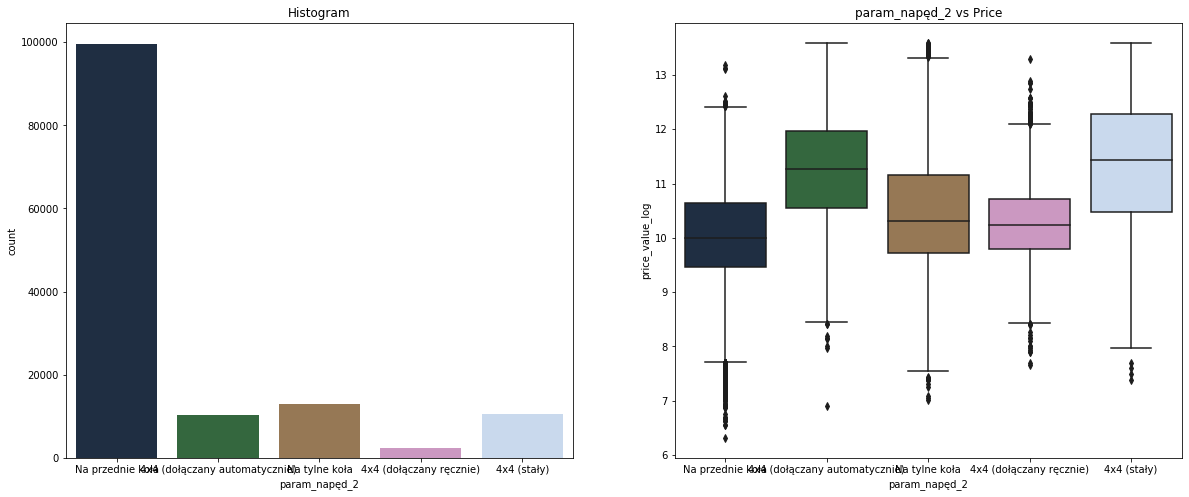

168: param_kolor_2 [99.90%=160455/160616 #14]: 
Czarny        39267
Srebrny       29515
Szary         21927
Biały         17687
Niebieski     17423
Inny kolor    11467
Czerwony       6246
Brązowy        4284
Zielony        3872
Bordowy        2850
Złoty          2448
Beżowy         2113
Fioletowy       736
Żółty           620
Name: param_kolor_2, dtype: int64


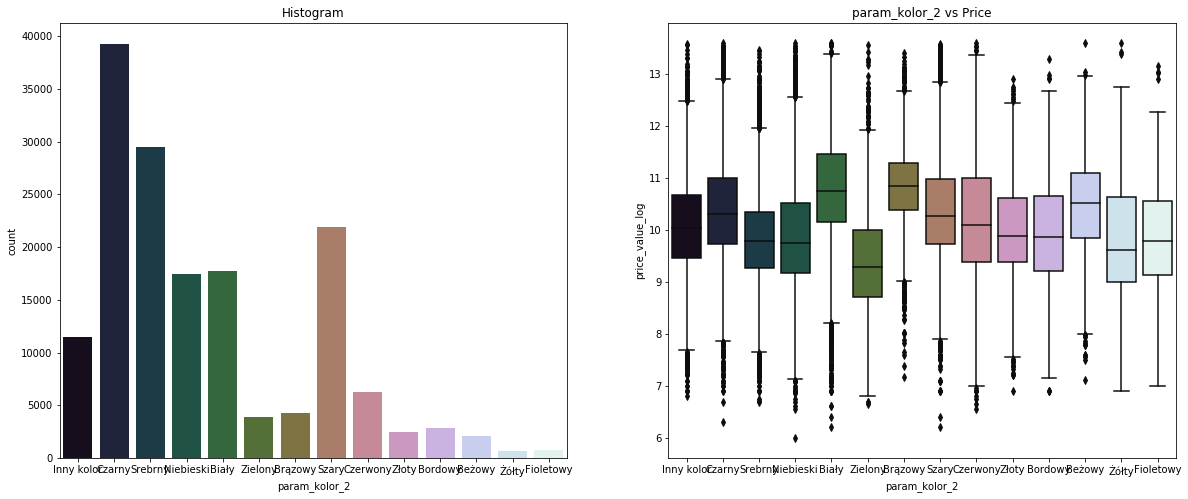

171: vin_where [100.00%=160616/160616 #42]: 
172: vin_flex_fuel [100.00%=160616/160616 #1466]: 
173: vin_portrait [100.00%=160616/160616 #6940]: 
174: vin_security [100.00%=160616/160616 #56]: 
175: vin_model [100.00%=160616/160616 #57]: 
176: vin_plant [100.00%=160616/160616 #57]: 
177: param_typ_2 [100.00%=160616/160616 #11]: 
Kombi            33012
Sedan            27052
Kompakt          24864
SUV              24266
Auta miejskie    20538
Minivan          19789
Auta małe         5407
Coupe             4051
Kabriolet         1430
_NA_Inne           164
Hatchback           43
Name: param_typ_2, dtype: int64


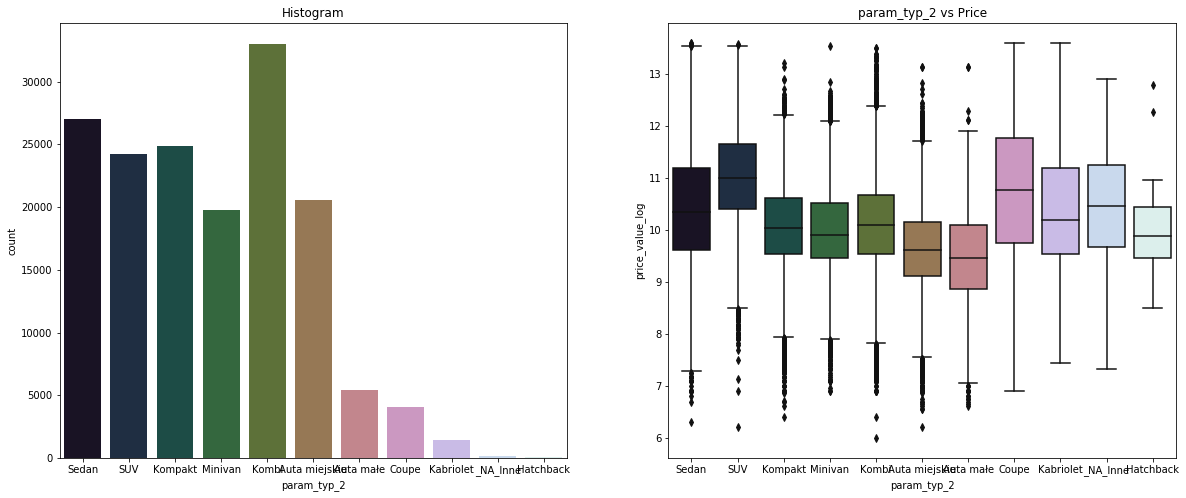

185: seller_wojewodzctwo [100.00%=160616/160616 #17]: 
Mazowieckie            28339
Wielkopolskie          23671
Śląskie                18390
Małopolskie            16104
Dolnośląskie           11977
Łódzkie                 9687
Pomorskie               9669
Lubelskie               7225
Kujawsko-pomorskie      6937
Zachodniopomorskie      5608
Podkarpackie            4886
Świętokrzyskie          4763
Warmińsko-Mazurskie     3757
Lubuskie                3116
Podlaskie               2926
Opolskie                2725
-1                       836
Name: seller_wojewodzctwo, dtype: int64


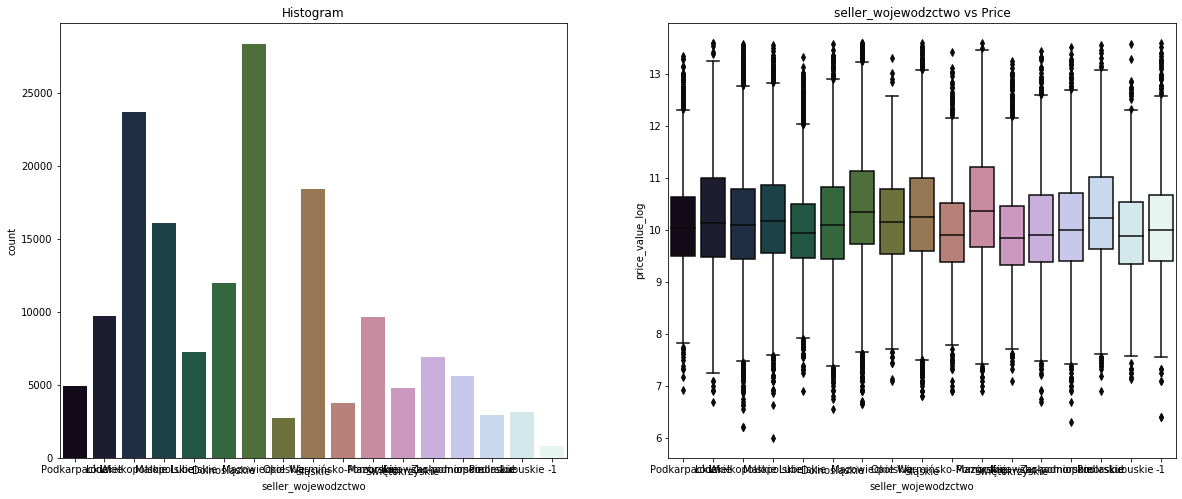

198: seller_miasto [99.91%=160467/160616 #5327]: 
200: encoded_seller_miasto_perc_40 [100.00%=160616/160616 #37]: 


In [5]:
print_plots_by_type(total, type =[np.object])

In [ ]:
## modelowanie

In [257]:
train_30 = pd.read_hdf('output/train_30.h5', 'data') 
test_car_ids = train_30['car_id'].values

train_70 = total[~total['car_id'].isin(test_car_ids) & ~total['price_value'].isna()]
train_30 = total[total['car_id'].isin(test_car_ids)]

print(len(total.index))
print(len(total[~total['price_value'].isna()].index))

print(train_70['price_value'].isna().sum())
print(train_30['price_value'].isna().sum())

train_100 = total[~total['price_value'].isna()]
print(train_100['price_value'].isna().sum())

global_min = total[~total['price_value'].isna()].price_value.min()

test = total[total['price_value'].isna()]
train = total[~total['price_value'].isna()]


160616
106494
0
0
0


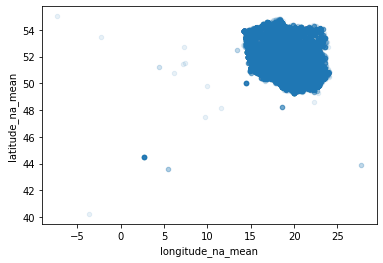

In [196]:
total.plot(kind="scatter", x="longitude_na_mean", y="latitude_na_mean", alpha=0.1)

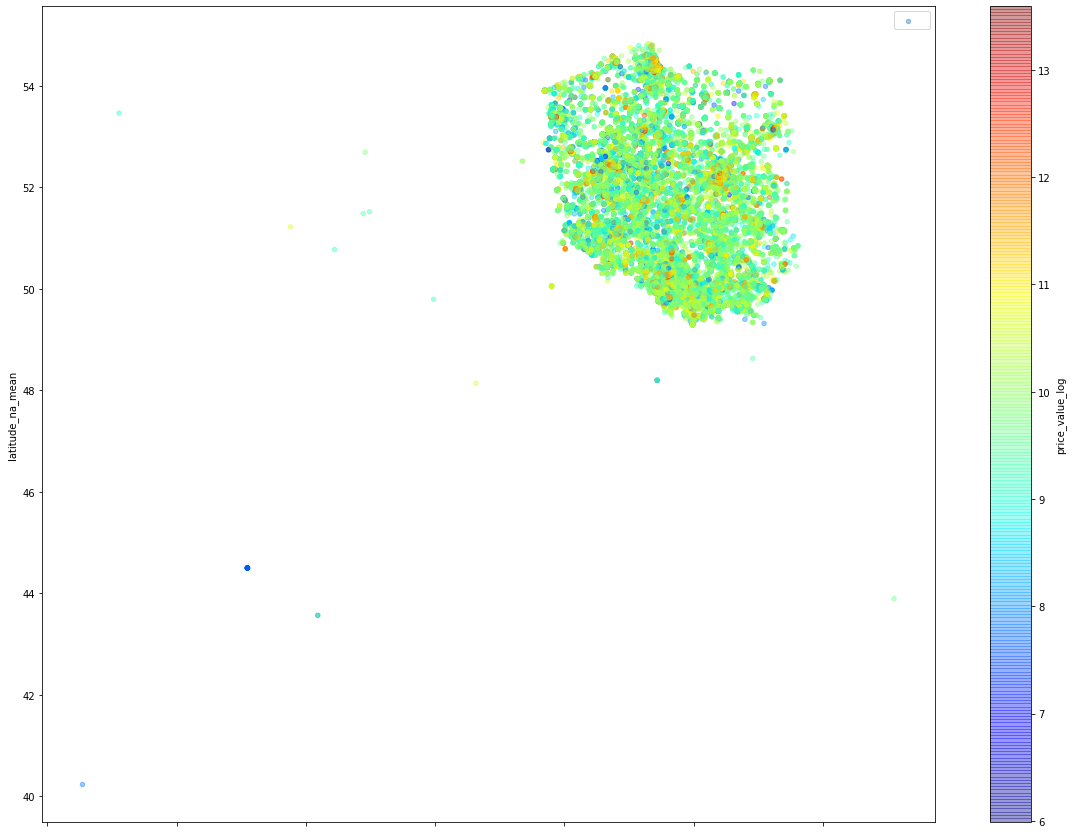

In [202]:
total.plot(kind="scatter", x="longitude_na_mean", y="latitude_na_mean", alpha=0.4,
 label="", figsize=(20,15),# s= total['encoded_seller_miasto_perc_40'], 
c="price_value_log", cmap=plt.get_cmap("jet"), colorbar=True,
)

black_list = ['car_id', 'price_details', 'price_value', 'price_value_log', 'price_value_pln', 'price_value_pln_log_transl', 'new_cat_price_value',
              *[x for x in total.columns if x.startswith('model_')],
              *total.columns[total.isnull().any()],
#               'encoded_price_currency', 
#               'price_currency_pln'
#               'created_at_unix_na_mean',
#               'created_at_unix', 
#               'pln_to_eur', 
#               'latitude', 'longitude', 
#               'latitude_na_mean', 'longitude_na_mean', 
#               'seller_address_cat', 'seller_name_cat', 'seller_type_cat', 
#               'new_cat_seller_address', 
#               'new_seller_address_cat', 'new_seller_name_cat', 'new_seller_type_cat', 
#               'new_param_vin_cat', 'param_vin_len', 
#               'new_param_rodzaj_paliwa_cat', 'new_param_skrzynia_biegów_cat', 'new_param_napęd_cat', 'new_param_kolor_cat', 'new_param_typ_cat',
#               'new_param_wartość_wykupu_cat', 'new_param_liczba_pozostałych_rat_cat', 'new_param_opłata_początkowa_cat', 'new_param_emisja_co2_cat', 'new_param_miesięczna_rata_cat',
#               'new_param_pierwsza_rejestracja_cat',
             ]

feats = total.select_dtypes(include=[np.number, np.bool]).columns

feats = [x for x in feats if x not in black_list]
feats = np.sort(feats)


start_vars=  [x for x in feats if (
              x.startswith('encoded_') 
              or x.startswith('param_') 
              or x.startswith('new_param_') 
              
              or x.startswith('new_vin') 
              or x.startswith('ogloszenie') 
              or x.endswith('_norm') 
              or x.find('_rok') >= 0
              or x.find('_lat') >= 0
            )
             ]
start_vars = np.sort(start_vars)

print(total[start_vars].info(verbose=True))
print(total[feats].info(verbose=True))

print(total[feats].columns[total[feats].isnull().any()])

In [10]:
start_vars = ['encoded_param_napęd_2', 'encoded_param_rodzaj_paliwa_2', 'encoded_param_skrzynia_biegów_2', 'encoded_param_typ_2', 'feature_asystent_pasa_ruchu', 'feature_cd', 'feature_czujnik_zmierzchu', 'feature_hud__wyświetlacz_przezierny_', 'feature_nawigacja_gps', 'feature_podgrzewane_przednie_siedzenia', 'feature_regulowane_zawieszenie', 'feature_relingi_dachowe', 'feature_system_start_stop', 'feature_szyberdach', 'feature_łopatki_zmiany_biegów', 'feature_światła_xenonowe', 'longitude', 'new_cat_seller_address', 'new_param_emisja_co2_cat', 'new_param_kategoria_cat', 'new_param_kod_silnika_cat', 'new_param_kolor_cat', 'new_param_kraj_pochodzenia_cat', 'new_param_liczba_pozostałych_rat_cat', 'new_param_marka_pojazdu_cat', 'new_param_miesięczna_rata_cat', 'new_param_model_pojazdu_cat', 'new_param_napęd_cat', 'new_param_oferta_od_cat', 'new_param_pierwsza_rejestracja_cat', 'new_param_rodzaj_paliwa_cat', 'new_param_stan_cat', 'new_param_typ_cat', 'new_param_wartość_wykupu_cat', 'new_param_wersja_cat', 'new_seller_wojewodzctwo_cat', 'new_vin_plant_cat', 'new_vin_security_cat', 'new_vin_where_cat', 'ogloszenie_dzien_tyg', 'ogloszenie_godzina', 'ogloszenie_miesiac', 'ogloszenie_rok', 'param_akryl__niemetalizowany_', 'param_bezwypadkowy', 'param_faktura_vat', 'param_filtr_cząstek_stałych', 'param_ile_lat_temu_produkcja', 'param_kierownica_po_prawej__anglik_', 'param_liczba_drzwi', 'param_liczba_pozostałych_rat_2', 'param_matowy', 'param_metalik', 'param_miesięczna_rata_2', 'param_moc', 'param_możliwość_finansowania', 'param_opłata_początkowa_2', 'param_pierwsza_rejestracja_10_lat', 'param_pierwsza_rejestracja_poprzedni_rok', 'param_pierwsza_rejestracja_ten_rok', 'param_pierwszy_właściciel', 'param_pojemność_skokowa', 'param_przebieg', 'param_rok_produkcji', 'param_rok_produkcji_10_lat', 'param_rok_produkcji_poprzedni_rok', 'param_rok_produkcji_ten_rok', 'param_tuning', 'param_uszkodzony', 'param_vat_discount', 'param_vat_free', 'param_vat_marża', 'param_vin_len', 'param_wartość_wykupu_2', 'param_zarejestrowany_jako_zabytek', 'param_zarejestrowany_w_polsce', 'price_currency_pln']
print(total[start_vars].info(verbose=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160616 entries, 0 to 160615
Data columns (total 77 columns):
 #   Column                                    Non-Null Count   Dtype  
---  ------                                    --------------   -----  
 0   encoded_param_napęd_2                     160616 non-null  int64  
 1   encoded_param_rodzaj_paliwa_2             160616 non-null  int64  
 2   encoded_param_skrzynia_biegów_2           160616 non-null  int64  
 3   encoded_param_typ_2                       160616 non-null  int64  
 4   feature_asystent_pasa_ruchu               160616 non-null  bool   
 5   feature_cd                                160616 non-null  bool   
 6   feature_czujnik_zmierzchu                 160616 non-null  bool   
 7   feature_hud__wyświetlacz_przezierny_      160616 non-null  bool   
 8   feature_nawigacja_gps                     160616 non-null  bool   
 9   feature_podgrzewane_przednie_siedzenia    160616 non-null  bool   
 10  feature_regulowane_z

In [69]:
def log_cosh_obj(preds, dtrain):
    x = preds - dtrain#.get_labels()
    grad = np.tanh(x)
    hess = 1 / np.cosh(x)**2
    return grad, hess

def fair_obj(preds, dtrain):
    """y = c * abs(x) - c**2 * np.log(abs(x)/c + 1)"""
    x = preds - dtrain#.get_labels()
    c = 0.7
    den = abs(x) + c
    grad = c*x / den
    hess = c*c / den ** 2
    return grad, hess

def huber_approx_obj(preds, dtrain):
    d = preds - dtrain#.get_labels() #remove .get_labels() for sklearn
    h = 1  #h is delta in the graphic
    scale = 1 + (d / h) ** 2
    scale_sqrt = np.sqrt(scale)
    grad = d / scale_sqrt
    hess = 1 / scale / scale_sqrt
    return grad, hess

def ln_exp_obj(preds, dtrain):
    x = preds - dtrain#.get_labels()
    exp_2x = np.exp(2*x)
    grad = (exp_2x - 1) / (exp_2x + 1)
    hess = (4 * exp_2x) / (exp_2x + 1) ** 2
    return grad, hess

shift = 10

def mae_log_eval(y_log_pred, dtrain):
    y_log_true = dtrain#.get_label()
    
    y_true = np.exp(y_log_true) - shift    
    y_pred = np.exp(y_log_pred) - shift
    
    return 'mae', mean_absolute_error(y_true, y_pred)

def eval_mae(y_pred_log, dtrain):
    y      = np.exp(dtrain.get_label()) - shift
    y_pred = np.exp(y_pred_log) - shift
    
    return 'mae', mean_absolute_error(y,y_pred)

# feats = start_vars
# X_train1 = train_70[ feats ].values
# y_train1 = np.log( train_70['price_value'].values + shift )

# X_test1 = train_30[ feats ].values
# y_test1 = np.log (train_30['price_value'].values + shift)

# eval_set = [(X_train1, y_train1), (X_test1, y_test1)]


In [258]:
params = {  
#     'objective' : fair_obj, 
    'objective' : 'reg:squarederror', 
    
    'n_jobs': 12, 

    'n_estimators': 10, 
    'learning_rate': 0.1, 
    'subsample': 0.9, 
    'colsample_bytree': 0.9,
    'max_depth': 40, 
        
#     'n_estimators': 90,#879, 
#     'learning_rate': 0.017354274677292683, 
#     'subsample': 0.923403370465418,
#     'colsample_bytree': 0.8797393544001986, 
#     'max_depth': 43, 
#     'min_child_weight': 48, 
#     'reg_alpha': 1.1048264246167496, 
#     'reg_lambda': 0.7451037079565321, 
#     'random_state': 6950, 
}

# model = xgb.XGBRegressor(**params)
# eval_set = [(X_train1, y_train1), (X_test1, y_test1)]

# model.fit(X_train1, y_train1
#           , eval_metric=eval_mae, eval_set=eval_set, verbose=False, early_stopping_rounds=5
#          )

# y_pred_log = model.predict(X_test1)
# # y_pred_log[ y_pred_log < 0 ] = global_min
# y_pred = np.exp( y_pred_log ) - shift

# mean_absolute_error(train_30['price_value'].values, y_pred)

mae, r2, model, model_cl, learning_curve_plot = train_and_submit(train_70, train_30, total.loc[total['price_value'].isna(),], 
                 start_vars, global_min, 
                 xgb.XGBRegressor, params, digitize="mpvp1", #None, # 
                 file_sufix = 'vars_search_train_70', opis='', subfolder='medium',
                 learning_curve = False, 
                 add_model_column_min = -1, total = total, 
                 save_min=1000, kaggle_min=-1)


mea: 12992.2923862548
r2: 0.6627019084595613


/home/conda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:85: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead


In [ ]:
mea: 46374.99161940795


In [76]:
total['new_cat_price_value'].value_counts()

perc_65    5698
perc_40    5665
perc_15    5446
perc_80    5404
perc_50    5370
perc_20    5357
perc_70    5354
perc_90    5340
perc_10    5339
perc_85    5338
perc_95    5328
perc_25    5310
perc_30    5282
perc_05    5280
perc_45    5245
perc_75    5242
perc_60    5217
perc_00    5201
perc_35    5041
perc_55    5037
Name: new_cat_price_value, dtype: int64

In [91]:
total['price_value_min'] = total.groupby(['new_cat_price_value']).price_value.transform('min')
total['price_value_max'] = total.groupby(['new_cat_price_value']).price_value.transform('max')

In [93]:
total.loc[total['model_XGBRegressor_3422_09438_start_vars_train_100'] > total['price_value_max'], 
          ['price_value', 'model_XGBRegressor_3422_09438_start_vars_train_100', 'new_cat_price_value', 'price_value_min', 'price_value_max']]

,price_value,model_XGBRegressor_3422_09438_start_vars_train_100,new_cat_price_value,price_value_min,price_value_max
3,19500.0,19917.709,perc_35,17800.0,19899.0
8,17500.0,18131.838,perc_30,15800.0,17790.0
10,19800.0,21470.943,perc_35,17800.0,19899.0
18,43500.0,44952.080,perc_65,37900.0,44499.0
28,7500.0,8365.200,perc_05,5500.0,7799.0
...,...,...,...,...,...
106476,18900.0,20201.098,perc_35,17800.0,19899.0
106478,27700.0,29689.328,perc_50,25500.0,28890.0
106480,26700.0,29936.229,perc_50,25500.0,28890.0
106484,17900.0,21962.512,perc_35,17800.0,19899.0


In [94]:
total.loc[total['model_XGBRegressor_3422_09438_start_vars_train_100'] < total['price_value_min'], 
          ['price_value', 'model_XGBRegressor_3422_09438_start_vars_train_100', 'new_cat_price_value', 'price_value_min', 'price_value_max']]

,price_value,model_XGBRegressor_3422_09438_start_vars_train_100,new_cat_price_value,price_value_min,price_value_max
0,45100.0,43185.652,perc_70,44500.0,52899.0
13,19900.0,18552.176,perc_40,19900.0,22650.0
16,29900.0,27772.352,perc_55,28900.0,32899.0
21,19999.0,19141.945,perc_40,19900.0,22650.0
22,32900.0,29664.932,perc_60,32900.0,37899.0
...,...,...,...,...,...
106481,5500.0,4665.069,perc_05,5500.0,7799.0
106483,106160.0,78337.800,perc_85,79999.0,108990.0
106485,22900.0,21999.658,perc_45,22682.0,25499.0
106486,7800.0,6732.610,perc_10,7800.0,9799.0


In [110]:
total.loc[total['model_XGBRegressor_3422_09438_start_vars_train_100'] .isna(), 
          ['price_value', 'model_XGBRegressor_3422_09438_start_vars_train_100', 'new_cat_price_value', 'price_value_min', 'price_value_max']]

,price_value,model_XGBRegressor_3422_09438_start_vars_train_100,new_cat_price_value,price_value_min,price_value_max


In [117]:
train_30['model_XGBRegressor_3422_09438_start_vars_train_100'].values

0          43185.652
1          28163.629
2         241108.100
6         116683.695
19         67025.040
             ...    
106479     16038.293
106480     29936.229
106482     39553.527
106484     21962.512
106489     18594.440
Name: model_XGBRegressor_3422_09438_start_vars_train_100, Length: 31949, dtype: float64

In [161]:
def digitalize_prediction(y_pred, train_all):
    import pandas as pd

#     print(len(y_pred))
#     print(len(train_all))
    result = pd.DataFrame(pd.np.column_stack([train_all[['new_cat_price_value', 'price_value_min', 'price_value_max']], y_pred]))
    result = result.rename(columns={0: "new_cat_price_value", 1: "price_value_min", 2: "price_value_max", 3: "__model__"})         
#     print(len(result))

    result.loc[result['__model__'] < result['price_value_min'], '__model__'] = result.loc[result['__model__'] < result['price_value_min'], 'price_value_min']
    result.loc[result['__model__'] > result['price_value_max'], '__model__'] = result.loc[result['__model__'] > result['price_value_max'], 'price_value_max']
    
    return result['__model__'].values


digitalize_prediction(train_30['model_XGBRegressor_3422_09438_start_vars_train_100'].values, train_30)

/home/conda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  


,new_cat_price_value,price_value_min,price_value_max,__model__
0,perc_70,44500,52899,44500
1,perc_50,25500,28890,28163.6
2,perc_95,165000,799900,241108
3,perc_90,109000,164995,116684
4,perc_80,64900,79997,67025
...,...,...,...,...
31944,perc_35,17800,19899,17800
31945,perc_50,25500,28890,28890
31946,perc_65,37900,44499,39553.5
31947,perc_35,17800,19899,19899


In [153]:
digitalize_prediction(test['model_XGBRegressor_3422_09438_start_vars_train_100'].values, test)

54122
54122
54122


/home/conda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  # Remove the CWD from sys.path while we load stuff.


,new_cat_price_value,price_value_min,price_value_max,__model__
0,NaN,NaN,NaN,5999.76
1,NaN,NaN,NaN,71182.7
2,NaN,NaN,NaN,12266.6
3,NaN,NaN,NaN,21947.9
4,NaN,NaN,NaN,4117.87
...,...,...,...,...
54117,NaN,NaN,NaN,30982.4
54118,NaN,NaN,NaN,11274.1
54119,NaN,NaN,NaN,9281.56
54120,NaN,NaN,NaN,21476.7


In [162]:
digitalize_prediction(total['model_XGBRegressor_3422_09438_start_vars_train_100'].values, total)

/home/conda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  


,new_cat_price_value,price_value_min,price_value_max,__model__
0,perc_70,44500,52899,44500
1,perc_50,25500,28890,28163.6
2,perc_95,165000,799900,241108
3,perc_35,17800,19899,19899
4,perc_90,109000,164995,164710
...,...,...,...,...
160611,NaN,NaN,NaN,30982.4
160612,NaN,NaN,NaN,11274.1
160613,NaN,NaN,NaN,9281.56
160614,NaN,NaN,NaN,21476.7


In [176]:
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold

from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
import xgboost as xgb

def cv_model(model, X, y, n_splits=3):

    scores = []
    skf = StratifiedKFold(n_splits=n_splits, random_state=2018, shuffle=True)

    for train_idx, test_idx in skf.split(X, y):
        model.fit(X[train_idx], y[train_idx])
        y_pred = model.predict_proba(X[test_idx])

        scores.append( log_loss(y[test_idx], y_pred) )
        
    return np.mean(scores), np.std(scores)

In [184]:
total.loc[total['new_cat_price_value'] == 'perc_05', 
          ['price_value', 'new_cat_price_value', 'price_value_min', 'price_value_max']]

,price_value,new_cat_price_value,price_value_min,price_value_max
28,7500.0,perc_05,5500.0,7799.0
35,6900.0,perc_05,5500.0,7799.0
60,5700.0,perc_05,5500.0,7799.0
85,7300.0,perc_05,5500.0,7799.0
97,7600.0,perc_05,5500.0,7799.0
...,...,...,...,...
106433,6000.0,perc_05,5500.0,7799.0
106449,7700.0,perc_05,5500.0,7799.0
106463,6000.0,perc_05,5500.0,7799.0
106481,5500.0,perc_05,5500.0,7799.0


In [183]:
xgb_params = {
    'objective': 'multi:softprob',
    'eval_metric': 'mlogloss',
    'max_depth': 5,
    'n_estimators': 50,
    'learning_rate': 0.17,
    'random_state': 2019,
}

cv_model(xgb.XGBClassifier(**xgb_params), train_70[start_vars].values, train_70['new_cat_price_value'].values)

(1.726394360660396, 0.0005611125060745547)

In [212]:
clasiffier = xgb.XGBClassifier(**xgb_params)

clasiffier.fit(train_70[start_vars].values, train_70['new_cat_price_value'].values)

total['mpvp1_'] = clasiffier.predict(total[start_vars].values)

In [239]:
print(total['new_cat_price_value'].value_counts())
print(total['mpvp1_'].value_counts())

perc_65    5698
perc_40    5665
perc_15    5446
perc_80    5404
perc_50    5370
perc_20    5357
perc_70    5354
perc_90    5340
perc_10    5339
perc_85    5338
perc_95    5328
perc_25    5310
perc_30    5282
perc_05    5280
perc_45    5245
perc_75    5242
perc_60    5217
perc_00    5201
perc_35    5041
perc_55    5037
Name: new_cat_price_value, dtype: int64
perc_65    11486
perc_40    10788
perc_00     9808
perc_05     9113
perc_80     9105
perc_15     8691
perc_90     8665
perc_10     8646
perc_70     8524
perc_95     8415
perc_85     8208
perc_50     8174
perc_30     8062
perc_20     7351
perc_75     7162
perc_60     6767
perc_25     6274
perc_55     5736
perc_45     4841
perc_35     4800
Name: mpvp1_, dtype: int64


In [251]:
def add_mpvp_min_max(mpvp_col, total):
    dictm = total[['new_cat_price_value', 'price_value_min', 'price_value_max']].drop_duplicates().to_dict()
    def get_from_dict(dictm, col, perc_val):
        index = [i for i, v in dictm.get('new_cat_price_value').items() if v == perc_val][0]
        return dictm.get(col).get(index)

    total[mpvp_col + '_' + 'price_value_min'] = total.apply(lambda row: get_from_dict(dictm, 'price_value_min', row['mpvp1_']), axis=1)
    total[mpvp_col + '_' + 'price_value_max'] = total.apply(lambda row: get_from_dict(dictm, 'price_value_max', row['mpvp1_']), axis=1)
    
    
total['mpvp1_price_value_max'] = -1
add_mpvp_min_max('mpvp1', total)

In [252]:
print(total['mpvp1_price_value_max'].value_counts())

44499.0     11486
22650.0     10788
5499.0       9808
7799.0       9113
79997.0      9105
11899.0      8691
164995.0     8665
9799.0       8646
52899.0      8524
799900.0     8415
108990.0     8208
28890.0      8174
17790.0      8062
13889.0      7351
64878.0      7162
37899.0      6767
15799.0      6274
32899.0      5736
25499.0      4841
19899.0      4800
Name: mpvp1_price_value_max, dtype: int64
